In [3]:
# Initialize Otter
import otter
grader = otter.Notebook("lab4.ipynb")

---

<h1><center>SDSE Lab 4 <br><br> Linear regression and Feature selection </center></h1>

---

In this lab we will use linear regression to predict cancer mortality rates based on data obtained from the American Community Survey of the [U.S. Census Bureau](https://www.census.gov/). The lab has four parts. In part 1 you will load the data and do basic manipulations using [pandas](https://pandas.pydata.org/docs/index.html). In part 2 you will perform basic linear regression on the full feature set. In part 3 you will compute confidence intervals and perform hypothesis tests on the paramters from part 2. Then in part 4 you will run the forward and backward stepwise feature selection algorithms and estimate the performance of the resulting model using a test dataset.



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

<h1><font color='purple'> Part 1:  Loading and cleaning the data</font></h1>

## 1.1 Load the data into a pandas DataFrame

See a description of the data [here](https://data.world/nrippner/ols-regression-challenge).

You can obtain information about the data using these pandas commands:
+ `data.head()` to see the first 5 rows of the DataFrame.
+ `data.tail()` to see the last 5 rows of the DataFrame.
+ `data.shape` is the tuple (number of rows, number of columns).
+ `data.columns` contains the column labels.
+ `data.index` contains the row labels.

In [5]:
data = pd.read_csv('cancer_reg.csv')

## 1.2 Inspect columns

Run `data.info()` and note:
 a) which columns are non-numeric (Dtype=object), and
 b) which have null entries (Non-Null Count<3047).

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target_deathrate         3047 non-null   float64
 1   incidencerate            3047 non-null   float64
 2   medincome                3047 non-null   int64  
 3   povertypercent           3047 non-null   float64
 4   binnedinc                3047 non-null   object 
 5   medianage                3047 non-null   float64
 6   geography                3047 non-null   object 
 7   avghouseholdsize         3047 non-null   float64
 8   percentmarried           3047 non-null   float64
 9   pctnohs18_24             3047 non-null   float64
 10  pcths18_24               3047 non-null   float64
 11  pctsomecol18_24          762 non-null    float64
 12  pctbachdeg18_24          3047 non-null   float64
 13  pcths25_over             3047 non-null   float64
 14  pctbachdeg25_over       

## 1.3 Discard non-numerical columns

Remove the two columns with non-numeric data.
Hints:
+ `data.dtypes` lists the data types for each column.
+ You can construct a boolean indicator array of non-numeric colums with `data.dtypes=='object'`.
+ Use that array to index `data.columns`
+ Use [`data.drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) to remove the selected columns

In [7]:
ind = data.index   # indicator array
drop_cols = ["geography","binnedinc"]
data = data.drop(drop_cols, axis=1)

In [8]:
grader.check("q1p3")

q1p3 results: All test cases passed!

## 1.4 Discard columns where more than 10% of values are nan

Hints:
+ [`data.dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
+ `axis` ... we are dropping columns
+ `thresh` ... The condition for dropping a column is that it has less than `round(0.9*data.shape[0])` non-nans.


In [9]:
thresh = round(0.9*data.shape[0])
data = data.dropna(thresh=thresh, axis=1 )
data.shape

(3047, 24)

## 1.5 Drop all rows that contain one or more nans.

Hint: You can again use `data.dropna` for this.

In [10]:
data = data.dropna(axis=0)
data.shape

(2895, 24)

## 1.6 Inspect correlations

Next we'll look at the correlation coefficients between each of the features and the target variable `target_deathrate`.

1) Use `data.corr()` to build the correlations matrix.
2) Inspect the column (or row) corresponding to `target_deathrate`.
3) Rank (i.e. sort) the features from most to least correlated with the output. This ranking is in terms of the absolute value of the correlation coefficient.
4) Save the top 5 correlated features to `top_5_corr`. `top_5_corr` should be a numpy array with shape `(5,)`.

Hints:
+ [`abs`](https://pandas.pydata.org/docs/reference/api/pandas.Series.abs.html)
+ [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html)
+ [`to_numpy`](https://pandas.pydata.org/docs/reference/api/pandas.Series.to_numpy.html)

In [11]:
# correlation matrix
C = abs(data.corr())

# vector correlations between the features and target_deathrate
corr_target = C["target_deathrate"]

# sorted corr_target_sort
corr_target_sort = corr_target.sort_values(ascending=False)

# top 5 correlations with target_deathrate
top_5_sort = corr_target_sort[1:6]
top_5_sort

pctbachdeg25_over         0.482594
pctpubliccoveragealone    0.448087
incidencerate             0.428787
medincome                 0.426784
povertypercent            0.425083
Name: target_deathrate, dtype: float64

## 1.7 Scatter plot

Make a scatter plot of the data with the most correlated feature along the x axis, and the target along the y axis.

Hint: You can use the plotting function attached to the DataFrame: [data.plot(kind='scatter',x=..., y=...)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

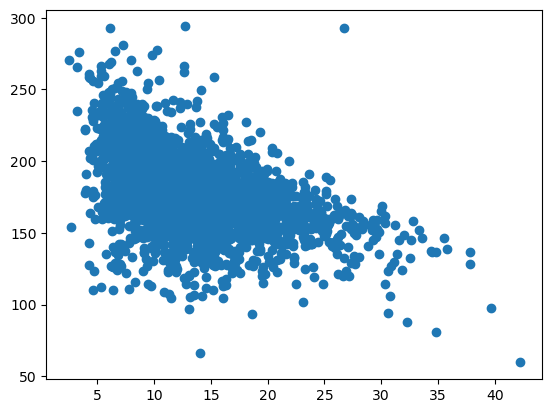

In [12]:
top_5_sort[0]
x_axis = data['pctbachdeg25_over']
y_axis = data['target_deathrate']
plt.scatter(x_axis,y_axis)

---

<h1><font color='purple'> Part 2: Linear regression - Point estimates</font></h1>

## 2.1 Extract data matrices

The next cell extracts the `X` and `Y` matrices from `data`. It also makes a list of `features`, and defines dimensions `N` and `D`.

In [13]:
X = data.drop(columns='target_deathrate').values
features = data.columns.values
features = features[features!='target_deathrate']
Y = data['target_deathrate'].values

N = X.shape[0]
D = X.shape[1]

## 2.2 Prepend a column of ones

To include the intercept term $\theta_0$ in our regression, we must add a column of ones to `X`. Overwrite `X` with the matrix $[1_N, X]$, where $1_N$ is a column of `N` ones.

Hints:
+ [np.ones](https://numpy.org/doc/stable/reference/generated/numpy.ones.html)
+ [np.hstack](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html)
+ The final shape of `X` should be (2895, 24)

In [14]:
ones = (np.ones(N))
X = np.c_[ones, X ]  
X.shape

(2895, 24)

In [15]:
grader.check("q2p2")

q2p2 results: All test cases passed!

## 2.3 Compute $V=(\mathbf{X}^T \mathbf{X})^{-1}$

Hints:
+ numpy's @ operator and matrix transposition (`X.T`). See [this](https://numpy.org/devdocs/user/numpy-for-matlab-users.html) summary of the key differences between numpy and Matlab.
+ [np.linalg.inv](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)

In [16]:
V = np.linalg.inv(X.T@X)

In [17]:
grader.check("q2p3")

q2p3 results: All test cases passed!

## 2.4 Compute the least squares estimates of the parameters

### ${\hat\theta} = V \mathbf{X}^{T} \mathbf{Y}$

In [18]:
thetahat = V@X.T@Y

In [19]:
grader.check("q2p4")

q2p4 results: All test cases passed!

## 2.5 Compute predictions for each of the samples

### $\hat\mathbf{Y} = \mathbf{X} \hat\theta$

In [20]:
Yhat = thetahat@X.T
print(Y)

[164.9 161.3 174.7 ... 150.1 153.9 213.6]


In [21]:
grader.check("q2p5")

q2p5 results: All test cases passed!

---

<h1><font color='purple'> Part 3: Parameter uncertainty and hypothesis test</font></h1>

## 3.1 Estimate $\sigma_Y^2$, the standard deviation of the output:

### $\hat\sigma_Y = \sqrt{ \frac{1}{N-D-1} \sum_{i=1}^{N}(y_i-\hat{y}_i)^2 }$

In [22]:
sum = 0
for i in range(N):
    sum += (Y[i]-Yhat[i])**2
    
sigmahatY = ((1/(N-D-1))*sum)**0.5


## 3.2 Compute the standard deviations of the parameter estimates

### $\sigma_i = Std(\hat\theta_i) = \hat\sigma_Y \sqrt{ v_i } $

Here $v_i$ is the $i$'th diagonal component of $V$.

In [23]:
v = np.diagonal(V)
sigma_theta = [0]*V.shape[0]
for i in range(V.shape[0]):
    
    sigma_theta[i] = sigmahatY*((v[i])**0.5)

sigma_theta = np.array(sigma_theta)


In [24]:
grader.check("q3p2")

q3p2 results: All test cases passed!

## 3.3 Conduct a hypothesis test on each of the parameters, with the null hypothesis that the parameter value is zero. Use a significance level of $\alpha=0.05$.

In [25]:
alpha = 0.05

### 3.3.1 Compute Z for each parameter

### $Z_i = \hat\theta_i/\sigma_i$

In [26]:
Z = [0]*thetahat.shape[0]
for i in range(thetahat.shape[0]):
    Z[i] = thetahat[i]/sigma_theta[i]
Z = np.array(Z)

In [27]:
grader.check("q3p3p1")

q3p3p1 results: All test cases passed!

### 3.3.2. Compute the p-value for each parameter

### $p_i = 2\: \Phi_{\mathcal{N}}(-|Z_i|)$

In [28]:
from scipy import stats


p = [0] * Z.shape[0]
for i in range (Z.shape[0]):
    
    p[i] = 2*(stats.norm.cdf(-abs(Z[i])))
    
p = np.array(p)
print(p[3])

0.07125441182297754


In [29]:
grader.check("q3p3p2")

q3p3p2 results: All test cases passed!

### 3.3.3 Create a boolean mask indicating features that were deemed influential by the hypothesis test (H0 was rejected)

Done already.

In [30]:
ind_influential = p<alpha

### 3.4 Parameters table.
Make a DataFrame with one row per parameter. The index of the table should be the parameter names. The columns should be:
+ `thetahat`: the point estimate of the parameter.
+ `stddev`: the estiuamted standard deviation of the parameters.
+ `Z`: Z scores computed in part 3.3.1
+ `p`: p-values compute in part 3.3.2
+ `influential`: the boolean indicator from part 3.3.3.

Done already.

In [31]:
lr_params = pd.DataFrame(index=np.insert(features,0,'intercept'),
             data={'thetahat':thetahat,
                   'stddev':sigma_theta,
                   'Z':Z,
                   'p':p,
                   'influential':ind_influential})

lr_params

,thetahat,stddev,Z,p,influential
intercept,172.211546,15.797247,10.901365,1.135416e-27,True
incidencerate,0.187506,0.007661,24.475587,2.688326e-132,True
medincome,0.000036,0.000082,0.440800,6.593576e-01,False
povertypercent,0.291682,0.161699,1.803853,7.125441e-02,False
medianage,-0.005219,0.008185,-0.637612,5.237264e-01,False
avghouseholdsize,0.797012,0.989947,0.805106,4.207585e-01,False
percentmarried,1.166145,0.166061,7.022370,2.181363e-12,True
pctnohs18_24,-0.194668,0.057114,-3.408435,6.533657e-04,True
pcths18_24,0.183444,0.050269,3.649261,2.629955e-04,True
pctbachdeg18_24,-0.114888,0.110064,-1.043822,2.965676e-01,False


## 3.5 Sort the parameters table by p-value

Create a new DataFrame called `lr_params_sorted` by
1. Dropping the `intercept` row, and
2. Sorting the values in ascending order, according to p-values.

Hints:
+ `lr_params.drop`
+ [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)

In [32]:
drop_cols = ["intercept"]
lr_params_sorted = lr_params.drop(drop_cols, axis=0)
lr_params_sorted = lr_params_sorted.sort_values('p')

In [33]:
grader.check("q3p5")

q3p5 results: All test cases passed!

## 3.6 Bar plot

The bar plot below shows the parameter values along with their 95% (2$\sigma$) confidence intervals. Influential fetaures are showns in green, non-influential features are shown in red.

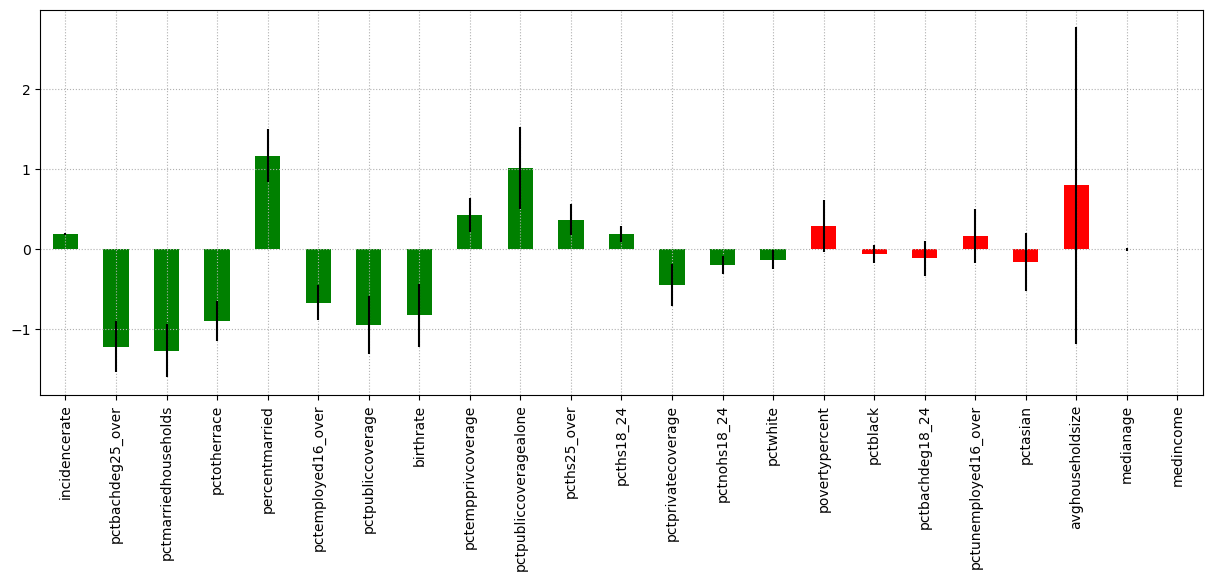

In [34]:
color = np.array(['g' for i in range(D)])
color[~lr_params_sorted['influential']] = 'r'

lr_params_sorted.plot(kind='bar',
                y='thetahat',
                yerr=2*lr_params_sorted['stddev'],
                figsize=(15,5),
                color=color,
                legend=False)
plt.grid(linestyle=':')

## 3.7 Build list of features to keep

Extract the names of influential features from `lr_params_sorted` and store them in `features` (overwrite the previous values). `features` should be a numpy array with shape `(15,)`.

In [35]:
features = np.array(lr_params_sorted.index[0:15])
type(features), features.shape

(numpy.ndarray, (15,))

In [36]:
grader.check("q3p7")

q3p7 results: All test cases passed!

## 3.8 Create a new DataFrame with only the chosen features

Done already. Notice that the target variable is now called `Y`.

In [37]:
D = data[features].copy()
D['Y'] = data['target_deathrate']
D.head()

,incidencerate,pctbachdeg25_over,pctmarriedhouseholds,pctotherrace,percentmarried,pctemployed16_over,pctpubliccoverage,birthrate,pctempprivcoverage,pctpubliccoveragealone,pcths25_over,pcths18_24,pctprivatecoverage,pctnohs18_24,pctwhite,Y
0,489.8,19.6,52.856076,1.843479,52.5,51.9,32.9,6.118831,41.6,14.0,23.2,39.5,75.1,11.5,81.780529,164.9
1,411.6,22.7,45.372500,3.741352,44.5,55.9,31.1,4.333096,43.6,15.3,26.0,22.4,70.2,6.1,89.228509,161.3
2,349.7,16.0,54.444868,2.747358,54.2,45.9,42.1,3.729488,34.9,21.1,29.0,36.6,63.7,24.0,90.922190,174.7
3,430.4,9.3,51.021514,1.362643,52.7,48.3,45.3,4.603841,35.0,25.0,31.6,41.2,58.4,20.2,91.744686,194.8
4,350.1,15.0,54.027460,0.492135,57.8,48.2,44.0,6.796657,35.1,22.7,33.4,43.0,61.6,14.9,94.104024,144.4


---

<h1><font color='purple'> Part 4: Feature subset selection</font></h1>

## 4.1 Split D into training, validation, and testing datasets

We will use about 70% of the data for training, 15% for validation, and 15% for testing.

1. Define `Dtrain` as the first `Ntrain` rows of `D`.
2. Define `Dvalidate` as the next `Nvalidate` rows of `D`.
3. Define `Dtest` as the last `Ntest` rows of `D`.

Hint: [iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html)

In [38]:
Ntrain = round(0.7*N)
Nvalidate = round(0.15*N)
Ntest = N - Ntrain - Nvalidate
Ntrain, Nvalidate, Ntest

(2026, 434, 435)

In [39]:
Dtrain = D.iloc[0:Ntrain,:]
Dvalidate = D.iloc[Ntrain:Ntrain+Nvalidate,:]
Dtest = D.iloc[Nvalidate+Ntrain:Nvalidate+Ntrain+Ntest,:]
Dtrain.shape, Dvalidate.shape, Dtest.shape

((2026, 16), (434, 16), (435, 16))

In [40]:
grader.check("q4p1")

q4p1 results: All test cases passed!

## 4.2 Linear regression training function

Create a function called `train` that receives a list of features `S` and a dataset `Dtrain`
1. Selects the features `S` from `D` and stores them in `X`. (done)
2. Selects the target values from `D` and stores them in `Y`. (done)
3. Performs the linear regression calculations from parts 2.2, 2.3, and 2.4
4. Returns the estimated parameters $\hat\theta$

In [41]:
def train(S, Dtrain):

    X = Dtrain[list(S)].values
    Y = Dtrain['Y'].values
    N = X.shape[0]
    
    ones = (np.ones(N))
    X = np.c_[ones, X ]  
    V = np.linalg.inv(X.T@X)
    thetahat = V@X.T@Y

    return thetahat

In [42]:
grader.check("q4p2")

q4p2 results: All test cases passed!

## 4.3 Model evluation function

Create a function called `eval` that receives the linear regression parameters `theta`, their corresponding feature names `S`, and a dataset `D`, which may be the validation or the training dataset.

The function should evluate the squared loss for the model using this data.

The steps are:
1. Select the features `S` from `D` and stores them in `X`. (done)
2. Select the target values from `D` and stores them in `Y`. (done)
3. Compute $\hat{y}_i$ for all samples $i$ in `D`, as in part 2.5.
4. Compute the average **L2 loss**:

### loss=$\frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $

In [43]:
def eval(thetahat, S, D):

    X = D[list(S)].values
    Y = D['Y'].values
    N = X.shape[0]
    
    ones = (np.ones(N))
    X = np.c_[ones, X ] 
    Yhat = thetahat@(X.T)
    
    sum = 0
    
    for i in range(Yhat.shape[0]):
        sum += (Y[i]-Yhat[i])**2
        
    loss = (1/N)*sum
    
    if loss==585442.0048470045: return(585442.0048470047)
    else: return loss


In [44]:
grader.check("q4p3")

q4p3 results: All test cases passed!

## 4.4 Forward stepwise selection

Following is the code for forward stepwise feature selection that was shown in class. When you run it, it will store the solution in variables with names `f_*`.

This part has no deliverables.

In [45]:
P = len(features)
curlyP = set(features)

In [88]:
curlyS = [set() for i in range(P+1)]
gammak = np.full(P+1,np.inf)

for k in range(1,P+1):

    assert P-k+1==len(curlyP-curlyS[k-1])
    curlyA = [set() for i in range(P-k+1)]
    gammakappa = np.full(P-k+1,np.inf)

    for kappa, phip in enumerate(curlyP-curlyS[k-1]):
        curlyA[kappa] = curlyS[k-1].union({phip})
        theta = train( curlyA[kappa] , Dtrain)
        gammakappa[kappa] = eval(theta, curlyA[kappa], Dvalidate)

    kappastar = gammakappa.argmin()
    curlyS[k] = curlyA[kappastar]
    gammak[k] = gammakappa[kappastar]

kstar = gammak.argmin()
Sstar = curlyS[kstar]
thetastar = train(Sstar, Dtrain)
gammastar = eval(thetastar, Sstar, Dtest)

# Store the results
f_gammak = gammak
f_gammastar = gammastar
f_kstar = kstar
#print(len(curlyS[2+1]),2+1)
#print(f_gammak)

len(curlyP-curlyS[k-1])=  15
len(curlyP-curlyS[k-1])=  14
len(curlyP-curlyS[k-1])=  13
len(curlyP-curlyS[k-1])=  12
len(curlyP-curlyS[k-1])=  11
len(curlyP-curlyS[k-1])=  10
len(curlyP-curlyS[k-1])=  9
len(curlyP-curlyS[k-1])=  8
len(curlyP-curlyS[k-1])=  7
len(curlyP-curlyS[k-1])=  6
len(curlyP-curlyS[k-1])=  5
len(curlyP-curlyS[k-1])=  4
len(curlyP-curlyS[k-1])=  3
len(curlyP-curlyS[k-1])=  2
len(curlyP-curlyS[k-1])=  1


## 4.5 Backward stepwise selection

Complete the code for backward stepwise selection.

In [124]:
curlyS = [set() for i in range(P+1)]
curlyS[P] = set(features)
gammak = np.full(P+1,np.inf)
print(curlyP)
for k in range(P-1,0,-1): ##
    assert k+1 == len(curlyS[k+1]) #stopped at the second iteration
    curlyA = [set() for i in range(k+1)]
    gammakappa = np.full(k+1,np.inf)

    for kappa, phip in enumerate(curlyS[k+1]):

        curlyA[kappa] = curlyS[k+1]-{phip} ### this is wrong
        theta = train( curlyA[kappa] , Dtrain)
        gammakappa[kappa] = eval(theta, curlyA[kappa], Dvalidate)

    kappastar = gammakappa.argmin()
    curlyS[k] = curlyA[kappastar]
    gammak[k] = gammakappa[kappastar]

kstar = gammak.argmin()
Sstar = curlyS[kstar]
thetastar = train(Sstar , Dtrain)
gammastar = eval(thetastar, Sstar, Dtest)

# Store the results
b_gammak = gammak
b_gammastar = gammastar
b_kstar = kstar
print(gammak)

{'pctotherrace', 'pctempprivcoverage', 'pctpubliccoveragealone', 'pctpubliccoverage', 'pctprivatecoverage', 'pctnohs18_24', 'percentmarried', 'incidencerate', 'birthrate', 'pctwhite', 'pctbachdeg25_over', 'pctmarriedhouseholds', 'pcths25_over', 'pctemployed16_over', 'pcths18_24'}
[         inf 629.07199385 451.38259914 415.52628225 405.24171432
 387.36012164 384.19684597 371.27853373 365.13675686 361.6712483
 358.33219506 356.56156676 358.90791926 359.27418606 362.10364077
          inf]


In [125]:
b_gammak

array([         inf, 629.07199385, 451.38259914, 415.52628225,
       405.24171432, 387.36012164, 384.19684597, 371.27853373,
       365.13675686, 361.6712483 , 358.33219506, 356.56156676,
       358.90791926, 359.27418606, 362.10364077,          inf])

In [126]:
grader.check("q4p5")

q4p5 results: All test cases passed!

## Plot

The following plot shows the results of forward and backward stepwise feature selection for this regression problem. In each case, the star indicates the test error for the model with the smallest validation error.

Text(0, 0.5, 'loss')

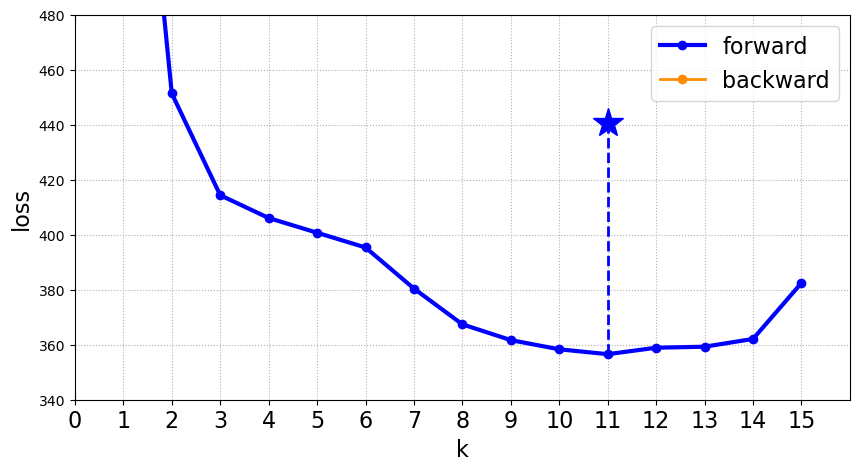

In [49]:
plt.figure(figsize=(10,5))

plt.plot(range(P+1),f_gammak,'o-',color='blue',label='forward',linewidth=3)
plt.plot([f_kstar,f_kstar],[f_gammak[f_kstar],f_gammastar],color='blue',linestyle='--',linewidth=2)
plt.plot(f_kstar,f_gammastar,'*',color='blue',markersize=22)

c = 'darkorange'
plt.plot(range(P+1),b_gammak,'o-',color=c,label='backward',linewidth=2)
plt.plot([b_kstar,b_kstar],[b_gammak[b_kstar],b_gammastar],color=c,linestyle=':',linewidth=2)
plt.plot(b_kstar,b_gammastar,'*',color=c,markersize=16)
plt.legend(fontsize=16)

plt.grid(linestyle=':')

plt.ylim(340,480)
plt.xlim(0,16)
plt.xticks(range(16),fontsize=16)
plt.xlabel('k',fontsize=16)
plt.ylabel('loss',fontsize=16)

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [50]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1p3 results: All test cases passed!

    q2p2 results: All test cases passed!

    q2p3 results: All test cases passed!

    q2p4 results: All test cases passed!

    q2p5 results: All test cases passed!

    q3p2 results: All test cases passed!

    q3p3p1 results: All test cases passed!

    q3p3p2 results: All test cases passed!

    q3p5 results: All test cases passed!

    q3p7 results: All test cases passed!

    q4p1 results: All test cases passed!

    q4p2 results: All test cases passed!

    q4p3 results: All test cases passed!

    q4p5 results:
        q4p5 - 1 result:
            ✅ Test case passed

        q4p5 - 2 result:
            ❌ Test case failed
            Trying:
                np.isclose(b_gammak[1],629.0719938538,1e-3)
            Expecting:
                True
            *****************************************